# Parameter Heatmap
<https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html>

In [1]:
from backtesting.test import SMA
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()

## Grid Search

In [2]:
%%time 

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

CPU times: user 408 ms, sys: 133 ms, total: 542 ms
Wall time: 7.04 s


In [3]:
heatmap

n1   n2   n_enter  n_exit
20   60   15       10        10102.86700
     80   15       10         9864.21924
     100  15       10        11003.21764
30   40   20       15        11771.28610
          25       15        16178.54842
                                ...     
100  200  15       10        13118.24766
          20       10        11308.46180
                   15        16350.94380
          25       10         8991.55294
          30       10         9953.07010
Name: Equity Final [$], Length: 177, dtype: float64

In [4]:
# top 3 best run
heatmap.sort_values().iloc[-3:]

n1   n2   n_enter  n_exit
100  120  15       10        18159.06414
     160  20       15        19216.54456
50   160  20       15        19565.69222
Name: Equity Final [$], dtype: float64

In [5]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
20,NaN,10102.867000,9864.219240,11003.217640,NaN,NaN,NaN,NaN,NaN
30,13974.91726,11696.318673,11757.991340,15092.994270,13152.243360,11518.686895,11271.353850,11384.550965,10649.052688
40,NaN,13666.448095,NaN,7549.099980,10629.479030,12860.993870,11405.291153,10863.807380,10658.139865
50,NaN,8383.464960,10180.502548,10563.790150,9081.947013,14272.265500,13575.860855,11383.464993,10053.468620
60,NaN,NaN,9232.415117,8046.485900,10838.454280,12876.589427,10312.954633,9427.545100,9555.402033
70,NaN,NaN,14712.143280,7192.892540,10403.014630,10065.279860,8293.733687,9895.782090,9360.478292
80,NaN,NaN,NaN,10863.108515,7721.243967,9139.946300,8813.949990,10414.656200,8908.486500
90,NaN,NaN,NaN,8958.143200,9538.050067,9884.415550,9685.919510,11343.643830,8806.572300
100,NaN,NaN,NaN,NaN,11253.156553,7101.260447,11323.427430,10163.321700,11944.455260


<AxesSubplot:xlabel='n2', ylabel='n1'>

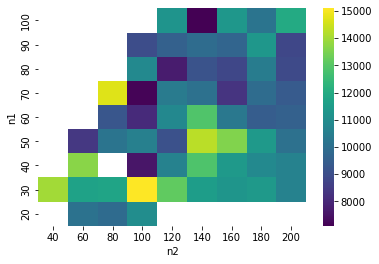

In [9]:
import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis')

## Model Based optimization